This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [5]:
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [6]:
# import standardized lat/long location data
train_data = pd.read_csv("train_data.csv")

In [7]:
train_data

,incwage,years_of_educ,potential_experience,non_white,sex
0,9.998798,12.000000,40.000000,0,1
1,9.998798,12.000000,6.000000,0,0
2,9.392662,12.000000,22.000000,0,0
3,9.740969,14.000000,11.000000,0,1
4,9.615805,0.085223,10.914777,0,0
...,...,...,...,...,...
66243,10.819778,13.000000,21.000000,0,0
66244,9.210340,16.000000,2.000000,0,0
66245,8.630522,13.000000,5.000000,0,1
66246,9.472705,12.000000,38.000000,0,0


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [8]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    norm_train = train_data.copy()
    norm_train.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.transform(norm_train.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience']])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX, columns=['incwage', 'years_of_educ', 'potential_experience'])
        sXs.append(sX)

    ####################################################################################################
        
    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience']], y=norm_train.loc[:, "non_white"])
    
    node_indicators = cart_non_white.decision_path(norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [norm_train.loc[:, 'non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience', 'non_white']], y=norm_train.loc[:, "sex"])
    
    node_indicators = cart_sex.decision_path(norm_train.loc[:, ['incwage', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [norm_train.loc[:, 'sex'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(norm_train, Y) for Y in sXs]

    # convert sXs to original scale (un-normalize?)
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
        scaler = StandardScaler().fit(H)
        Z.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(Z.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        Z.loc[:, ['years_of_educ']] = np.round(Z.loc[:, ['years_of_educ']], 0)
    
    return pmse_ratios, sXs, GMM

In [9]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_non_white_, mb_sex_):

        pmse_ratios, _, _ = train_models(train_data=train_data,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         number_gmm_initializations=number_gmm_initializations,
                                         num_components_=int(num_components_),
                                         mb_non_white_=int(mb_non_white_),
                                         mb_sex_=int(mb_sex_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_non_white_": (10, 350.99),
            "mb_sex_": (10, 350.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [10]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [12]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | mb_non... |  mb_sex_  | num_co... |
-------------------------------------------------------------
| 1         | -2.174    | 78.88     | 345.1     | 197.3     |
| 2         | -2.932    | 260.6     | 149.6     | 128.2     |
| 3         | -1.649    | 37.02     | 146.1     | 125.6     |
| 4         | -14.51    | 163.6     | 177.5     | 79.62     |
| 5         | -2.463    | 108.6     | 349.4     | 166.0     |
| 6         | -1.472    | 10.0      | 129.3     | 157.4     |
| 7         | -2.63     | 10.0      | 192.2     | 159.9     |
| 8         | -7.904    | 10.0      | 92.3      | 103.0     |
| 9         | -1.119    | 37.61     | 145.3     | 125.8     |
| 10        | -0.9176   | 41.81     | 139.6     | 126.8     |
| 11        | -2.6      | 44.34     | 144.3     | 121.1     |
| 12        | -1.019    | 35.97     | 140.0     | 131.1     |
| 13        | -0.9504   | 35.35     | 138.1     | 123.4     |
| 14        | -0.9518   | 38.58     | 141.9     | 126.9     |
| 15    

***

In [13]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

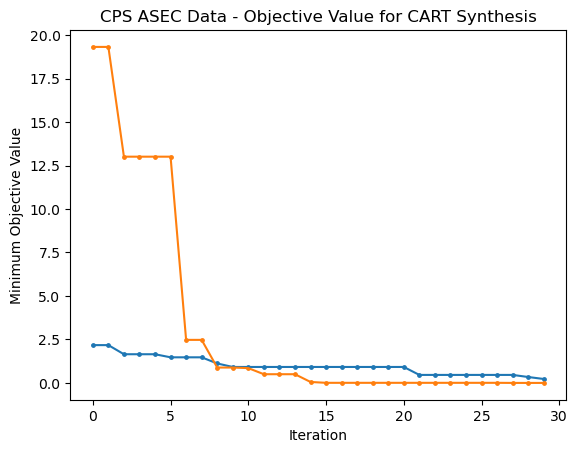

In [14]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("CPS ASEC Data - Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [15]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [16]:
best_params

{'target': -0.0001112965376390122,
 'params': {'mb_non_white_': 196.76951199317804,
  'mb_sex_': 10.0,
  'num_components_': 200.99}}

***

Generate 20 synthetic datasets.

In [17]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_non_white_=int(best_params['params']['mb_non_white_']))

In [18]:
np.mean(pmse_ratios)

1.4869687802817215

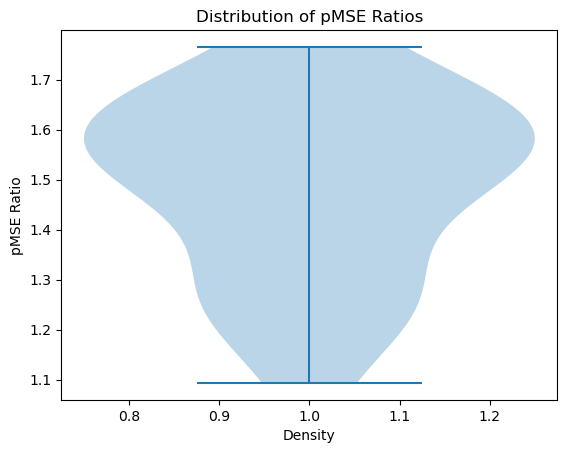

In [19]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [20]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("synthetic_train/sd_" + str(i) + ".csv", index=False)

***

In [18]:
# full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [19]:
# # load
# with open('../Results/IPUMS/Models/gmm_and_cart.pkl', 'rb') as f:
#     GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [20]:
# prior = np.mean(train_data.non_white == 1)

For our threshold, we select $c = 3$, i.e., we are allowing for a 3x increase in the probability of an adversary inferring the non-white status based on the synthetic data.

In [21]:
# prior

In [22]:
# c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [23]:
# deltas = np.linspace(0.001, 0.1, 5)

In [24]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
#                                          categorical_vars=['sex'],
#                                          sensitive_var='non_white',
#                                          mixture_model=GMM,
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

***

In [25]:
# num_records = train_data.shape[0]

In [26]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])

***

In [27]:
# for i, sX in enumerate(ad_sXs):

#     # normalize
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])

#     # reverse the normalization using means/sds from bootstrap sampled confidential data
#     H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
#     scaler = StandardScaler().fit(H)
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)
#     full_sXs[i].to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

***